In [1]:
from snn_delays.snn_refactored_capo_reciprocal import SNN
import torch
dataset_dict = {'num_input_i': 1000, 'num_input_j':1000, 'time_ms': 1000}
steps = 500
batch_size = 100

structure = [50, 50]

#snn = SNN(dataset_dict, [32, 64])

#tau_m = 'lognormal-st'

tau_m = 10.0

snn = SNN(dataset_dict, structure, win=steps, tau_m=tau_m, batch_size=batch_size, device='cpu')
snn.set_layers()

Delta t: 2.0 ms
Delta t: 2.0 ms


In [2]:
snn

SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): ReciprocalSNNLayer(
      (linear_i): Linear(in_features=1000, out_features=50, bias=False)
      (linear_j): Linear(in_features=1000, out_features=50, bias=False)
      (linear_ij): Linear(in_features=50, out_features=50, bias=False)
      (linear_ji): Linear(in_features=50, out_features=50, bias=False)
    )
  )
)

In [3]:
w_in_i = snn.layers[0].linear_i
w_in_j = snn.layers[0].linear_j
w_i_j = snn.layers[0].linear_ij
w_j_i = snn.layers[0].linear_ji

In [114]:
### one-to-one connections (num_i must equal num_j)
assert structure[0] == structure[1]
with torch.no_grad():
    #scaling_factor = 0.1
    scaling_factor = 10.0
    w_i_j.weight.data *= scaling_factor*torch.eye(structure[0])
    #w_j_i.weight.data *= scaling_factor*torch.eye(structure[0])
    w_j_i.weight.data = w_i_j.weight.data*(2.0)*torch.rand(structure[0]) # multiplied by a random with mean 1.0

In [115]:
def numpify(layer):
    return layer.weight.data.detach().cpu().numpy()


(50,)
(50,)
15.818906
0.0007204344
(50,)
(50,)
15.782588
0.0007247372


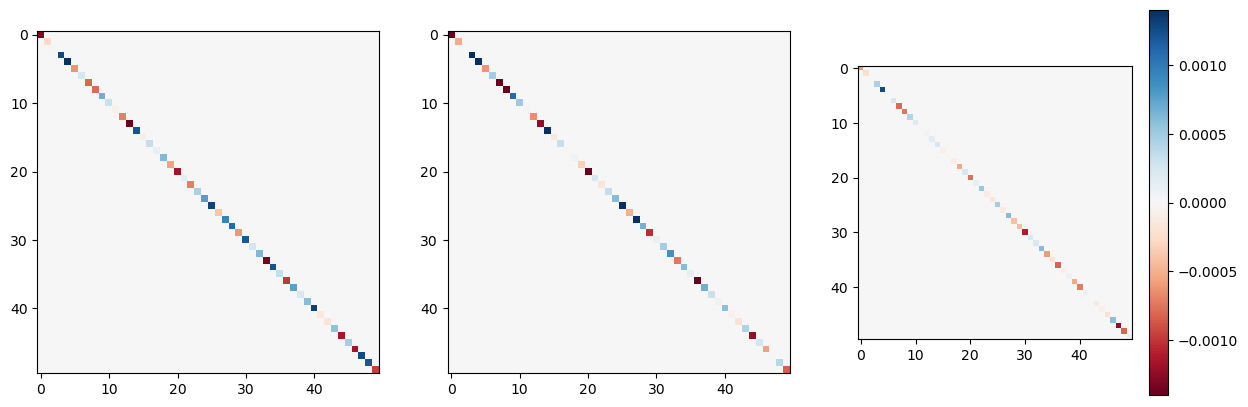

In [116]:
import numpy as np
import matplotlib.pyplot as plt

print(np.sum(numpify(w_in_i), axis=1).shape)
print(np.sum(numpify(w_j_i), axis=1).shape)

print(np.mean(np.sum(np.abs(numpify(w_in_i)), axis=1)))
print(np.mean(np.sum(np.abs(numpify(w_j_i)), axis=1)))

print(np.sum(numpify(w_in_j), axis=1).shape)
print(np.sum(numpify(w_i_j), axis=1).shape)

print(np.mean(np.sum(np.abs(numpify(w_in_j)), axis=1)))
print(np.mean(np.sum(np.abs(numpify(w_i_j)), axis=1)))

max_w  = np.max(numpify(w_i_j))
min_w  = np.min(numpify(w_i_j))

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(numpify(w_i_j), cmap='RdBu', vmin=min_w, vmax=max_w)
plt.subplot(132)
plt.imshow(numpify(w_j_i), cmap='RdBu', vmin=min_w, vmax=max_w)
plt.subplot(133)
plt.imshow(numpify(w_j_i)-numpify(w_i_j), cmap='RdBu', vmin=min_w, vmax=max_w)
plt.colorbar()

In [117]:
# linearize and concatenate numpify(w_in_i) and numpify(w_j_i)
#_ = plt.hist(np.concatenate((numpify(w_in_i).reshape(-1), numpify(w_j_i).reshape(-1))), bins=100)


In [118]:
# linearize and concatenate numpify(w_in_i) and numpify(w_j_i)
#_ = plt.hist(np.concatenate((numpify(w_in_j).reshape(-1), numpify(w_i_j).reshape(-1))), bins=100)

In [119]:
import torch

input_scale = 0.1
#input_scale = 1.0

inputs_i = input_scale*torch.abs(torch.randn(batch_size, steps, dataset_dict['num_input_i']))
inputs_j = input_scale*torch.abs(torch.randn(batch_size, steps, dataset_dict['num_input_j']))

In [120]:
all_i_mems, all_j_mems, all_i_spikes, all_j_spikes = snn(inputs_i, inputs_j)

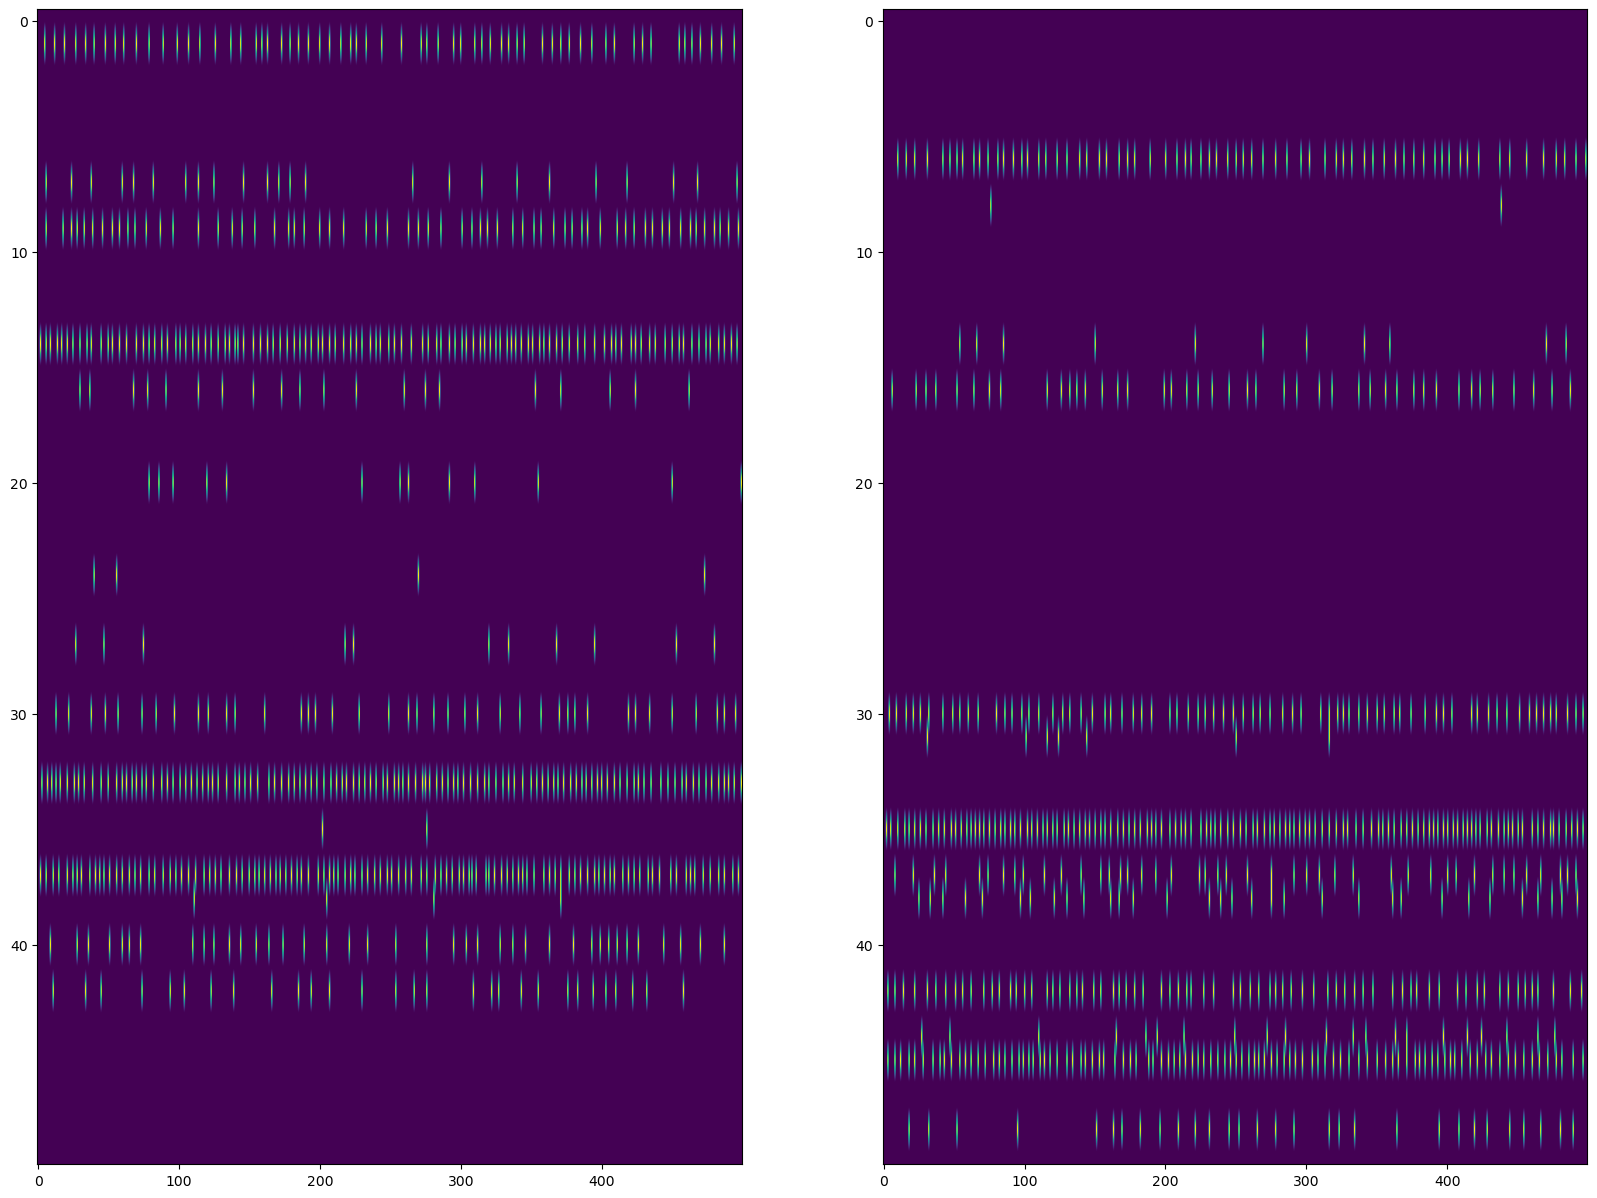

In [121]:
def plot_spikes(all_spikes, sample_id):

    all_spikes = all_spikes[:, sample_id, :].detach().cpu().numpy().T

    plt.imshow(all_spikes, aspect='auto')

plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plot_spikes(all_i_spikes, 0)
plt.subplot(1, 2, 2)
plot_spikes(all_j_spikes, 0)

In [122]:
pre_times = [1, 5, 7, 9, 11, 25]
post_times = [1, 6, 8, 10]

def get_delta_t(pre_times, post_times):
    """
    Get the delta t between pre and post times.
    :param pre_times: list of pre times
    :param post_times: list of post times
    :return: list of delta t values
    """
    # Find the closest post time for each pre time
    differences = []
    for post in post_times:
        closest_pre = min(pre_times, key=lambda pre: abs(post - pre))
        differences.append(post - closest_pre)
    return differences

print(get_delta_t(pre_times, post_times))

[0, 1, 1, 1]


In [123]:
#sample_id = 0

diffs_A = []
diffs_B = []
# diffs_C = [] 
# diffs_D = []

for sample_id in range(batch_size):

    for neuron_id in range(structure[0]):

        w_ij = numpify(w_i_j)[neuron_id, neuron_id]
        w_ji = numpify(w_j_i)[neuron_id, neuron_id]

        spk_i = all_i_spikes[:, sample_id, neuron_id]
        spk_j = all_j_spikes[:, sample_id, neuron_id]

        if torch.sum(spk_i) == 0 or torch.sum(spk_j) == 0:
            print(f"Skipping sample {sample_id}, neuron {neuron_id} due to no spikes")
            continue

        spk_i_times = list(torch.where(spk_i > 0)[0].cpu().numpy())
        spk_j_times = list(torch.where(spk_j > 0)[0].cpu().numpy())

        if w_ji > w_ij and w_ji>0 and w_ij>0:
            diffs_A += get_delta_t(spk_j_times, spk_i_times)
        elif w_ji < w_ij and w_ij<0 and w_ji<0:
            diffs_B += get_delta_t(spk_j_times, spk_i_times)


Skipping sample 0, neuron 0 due to no spikes
Skipping sample 0, neuron 1 due to no spikes
Skipping sample 0, neuron 2 due to no spikes
Skipping sample 0, neuron 3 due to no spikes
Skipping sample 0, neuron 4 due to no spikes
Skipping sample 0, neuron 5 due to no spikes
Skipping sample 0, neuron 6 due to no spikes
Skipping sample 0, neuron 7 due to no spikes
Skipping sample 0, neuron 8 due to no spikes
Skipping sample 0, neuron 9 due to no spikes
Skipping sample 0, neuron 10 due to no spikes
Skipping sample 0, neuron 11 due to no spikes
Skipping sample 0, neuron 12 due to no spikes
Skipping sample 0, neuron 13 due to no spikes
Skipping sample 0, neuron 15 due to no spikes
Skipping sample 0, neuron 17 due to no spikes
Skipping sample 0, neuron 18 due to no spikes
Skipping sample 0, neuron 19 due to no spikes
Skipping sample 0, neuron 20 due to no spikes
Skipping sample 0, neuron 21 due to no spikes
Skipping sample 0, neuron 22 due to no spikes
Skipping sample 0, neuron 23 due to no spike

In [124]:
len(diffs_A)

11489

In [125]:
len(diffs_B)

2360

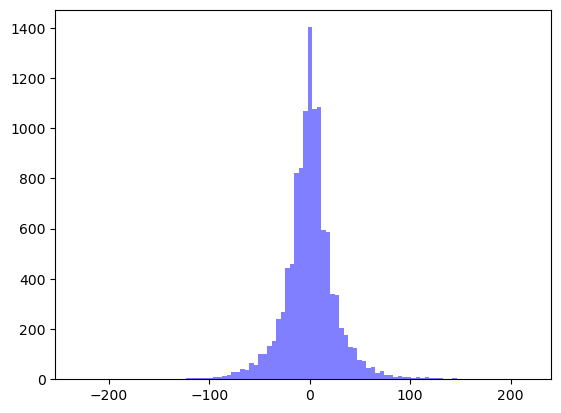

In [126]:
_ = plt.hist(diffs_A, bins=100, alpha=0.5, label='A', color='blue')

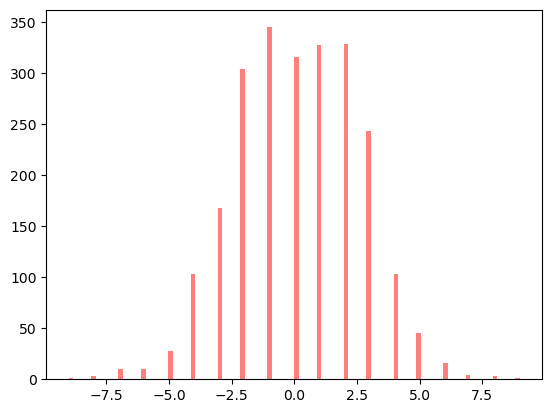

In [127]:
_ = plt.hist(diffs_B, bins=100, alpha=0.5, label='B', color='red')